In [14]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

%matplotlib inline 

import pandas as pd
from collections import defaultdict

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_balloon.h5")


In [15]:
import requests
from io import BytesIO
from PIL import Image
import pandas as pd

In [16]:
'''
conn = S3Connection('', '', anon=True)
bucket = conn.get_bucket('second-look')
key = bucket.get_key('mask_rcnn_roi_breast_tumors_patches1024_nr_0259.h5')
key.get_contents_to_filename('patches.h5')
key = bucket.get_key('mask_rcnn_coco.h5')
key.get_contents_to_filename('mask_rcnn_coco.h5')
'''

"\nconn = S3Connection('', '', anon=True)\nbucket = conn.get_bucket('second-look')\nkey = bucket.get_key('mask_rcnn_roi_breast_tumors_patches1024_nr_0259.h5')\nkey.get_contents_to_filename('patches.h5')\nkey = bucket.get_key('mask_rcnn_coco.h5')\nkey.get_contents_to_filename('mask_rcnn_coco.h5')\n"

# Configurations

In [17]:
class BreastTumorsConfig(Config):
    """Configuration for training on the toy tumors dataset.
    Derives from the base Config class and overrides values specific
    to the toy tumors dataset.
    """
    # Give the configuration a recognizable name
    NAME = "roi_breast_tumors_patches1024_NR"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    #NUM_CLASSES = 1 + 3  # background + 3 shapes
    # How many tumor shapes do we have?
    NUM_CLASSES = 1 + 3  # background + tumors

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 2831
    #STEPS_PER_EPOCH = 2205
    #STEPS_PER_EPOCH = 220

    # use small validation steps since the epoch is small
    VALIDATION_STPES = 626
    #VALIDATION_STPES = 63
    
    USE_MINI_MASK=False
    
config = BreastTumorsConfig()
config.print()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           roi_breast_tumors_patches1024_NR
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_

# Notebook Preferences 

In [18]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset

In [19]:
import skimage.color

class BreastTumorsDataset(utils.Dataset):
    
    def load_dataset(self, class_file1, image_dir1, mask_dir1, class_file2=None, image_dir2=None, mask_dir2=None):
        """
        Initialize the dataset with the images from dataset_dir folder.
        """
        
        # Add classes
        self.df_class1 = pd.read_csv(class_file1)
        
        self.add_class("bt_shapes", 1, 'NORMAL')
        self.add_class("bt_shapes", 2, 'BENIGN')
        self.add_class("bt_shapes", 3, 'MALIGNANT')
        
        for root, dirs, files in os.walk(image_dir1):
            for filename in files:
                self.add_image(
                    source='bt_shapes',
                    image_id=filename,
                    path=os.path.join(image_dir1, filename)
                )        
        
        self.mask_dir1 = mask_dir1

        if class_file2 != None:
            self.df_class2 = pd.read_csv(class_file2)
        
        if image_dir2 != None:
            for root, dirs, files in os.walk(image_dir2):
                for filename in files:
                    self.add_image(
                        source='bt_shapes',
                        image_id=filename,
                        path=os.path.join(image_dir2, filename)
                    )        
                
        self.mask_dir2 = mask_dir2
        
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        print(self.image_info[image_id]['path'])
        image = cv2.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image

    def load_mask(self, image_id):
        """Load masks for the given image ID.
        """
        imagepath = self.image_info[image_id]['path']
        
        image_dir, imagefile = os.path.split(imagepath)
        imagefilename, ext = os.path.splitext(imagefile)
        
        
        prefix, patient_id1, patient_id2, side, viewsuffix = imagefilename.split('_')
        view, abn, angle, patch_width, patch_height, hstride, vstride, row, column, pathology = viewsuffix.split('-')
        patient_id = patient_id1 + '_' + patient_id2
        abn_num = abn[1:]
        
        maskfile = prefix + '_' + \
                    patient_id + '_' + \
                    side + '_' + \
                    view + '_' + \
                    abn_num + '_' + \
                    'mask' + '-' + \
                    abn + '-' + \
                    angle + '-' + \
                    patch_width + '-' + \
                    patch_height + '-' + \
                    hstride + '-' + \
                    vstride + '-' + \
                    row + '-' + \
                    column + '-' + \
                    pathology + ext
                    
        maskfile = os.path.join(self.mask_dir1, maskfile)

        # Load mask
        print(maskfile)
        mask = cv2.imread(maskfile)
        
        # If grayscale. Convert to RGB for consistency.
        if mask.ndim != 3:
            mask = skimage.color.gray2rgb(mask)

        # Map class names to class IDs.
        if pathology == 'm':
            class_ids = np.array([3, 3, 3])
        else:
            class_ids = np.array([2, 2, 2])

        return mask, class_ids.astype(np.int32)
    
    
    def image_reference(self, image_id):
        """Return a link to the images in the folder"""
        info = self.image_info[image_id]
        if info["source"] == "bt_shapes":
            return self.image_info[image_id]['path']
        else:
            super(self.__class__).image_reference(self, image_id)
            

In [20]:
#Validation dataset
dataset_val = BreastTumorsDataset()

dataset_val.load_dataset(class_file1=os.path.join('data', 'mass_case_description_test_set.csv'), \
                          image_dir1=os.path.join('data', 'Mass-Test Full Mammogram Patches1024 NR'), \
                          mask_dir1=os.path.join('data', 'Mass-Test Full ROI Patches1024 NR'))


dataset_val.prepare()

In [21]:
dataset_val.image_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

# Create Model

In [22]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [23]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

AttributeError: module 'keras.engine.topology' has no attribute 'load_weights_from_hdf5_group_by_name'

## Detection

In [11]:
class InferenceConfig(BreastTumorsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights

#model_path = os.path.join(ROOT_DIR, 'logs', 'roi_breast_tumors_patches1024_nr20171125T0505', 'mask_rcnn_roi_breast_tumors_patches1024_nr_0259.h5')
model_path = os.path.join(ROOT_DIR,'patches.h5')
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Loading weights from  /home/kazzasti

OSError: Unable to open file (unable to open file: name = '/home/kazzastic/Desktop/Breast-Cancer-Lump-Segmentation-MaskRCNN/training/patches.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Malignant Case

Image id: 0
data/Mass-Test Full Mammogram Patches1024 NR/Mass-Test_P_00016_LEFT_CC-T1-A0-W1024-H1024-HS1024-VS1024-R3-C2-m.png
data/Mass-Test Full ROI Patches1024 NR/Mass-Test_P_00016_LEFT_CC_1_mask-T1-A0-W1024-H1024-HS1024-VS1024-R3-C2-m.png
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (12,)                 min:    0.00000  max: 1024.00000
gt_bbox                  shape: (3, 5)                min:    3.00000  max:  221.00000
gt_mask                  shape: (256, 256, 3)         min:    0.00000  max:  255.00000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  256.00000


/Users/ankithgunapal/Applications/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Detection time = 4.669277906417847 seconds


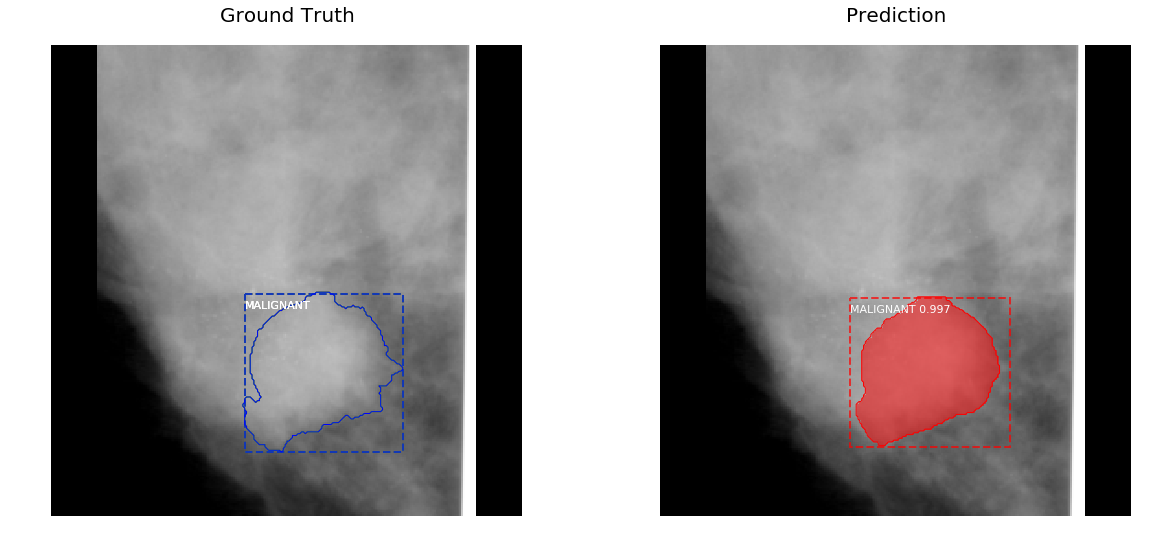

In [23]:
# Test on a random image
#image_id = random.choice(dataset_val.image_ids)
image_id = 0
print('Image id: {0}'.format(image_id))
original_image, image_meta, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

visualize.display_instances(original_image, gt_bbox[:,:4], gt_mask, gt_bbox[:,4], 
                            dataset_val.class_names, figsize=(8, 8),ax=ax1)


print()
start =  time.time()
results = model.detect([original_image], verbose=1)
end = time.time()

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax2)

ax1.set_title('Ground Truth', fontsize=20)
ax2.set_title('Prediction',fontsize=20)

fig.subplots_adjust(hspace=50)

print('Detection time = {0} seconds'.format(end-start))

# Benign Case

Image id: 12
data/Mass-Test Full Mammogram Patches1024 NR/Mass-Test_P_00056_LEFT_MLO-T1-A0-W1024-H1024-HS1024-VS1024-R4-C1-b.png
data/Mass-Test Full ROI Patches1024 NR/Mass-Test_P_00056_LEFT_MLO_1_mask-T1-A0-W1024-H1024-HS1024-VS1024-R4-C1-b.png
original_image           shape: (256, 256, 3)         min:    0.00000  max:  157.00000
image_meta               shape: (12,)                 min:    0.00000  max: 1024.00000
gt_bbox                  shape: (3, 5)                min:    0.00000  max:  169.00000
gt_mask                  shape: (256, 256, 3)         min:    0.00000  max:  255.00000

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  157.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   53.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  256.00000
Detection time = 4.422066926956177 seconds


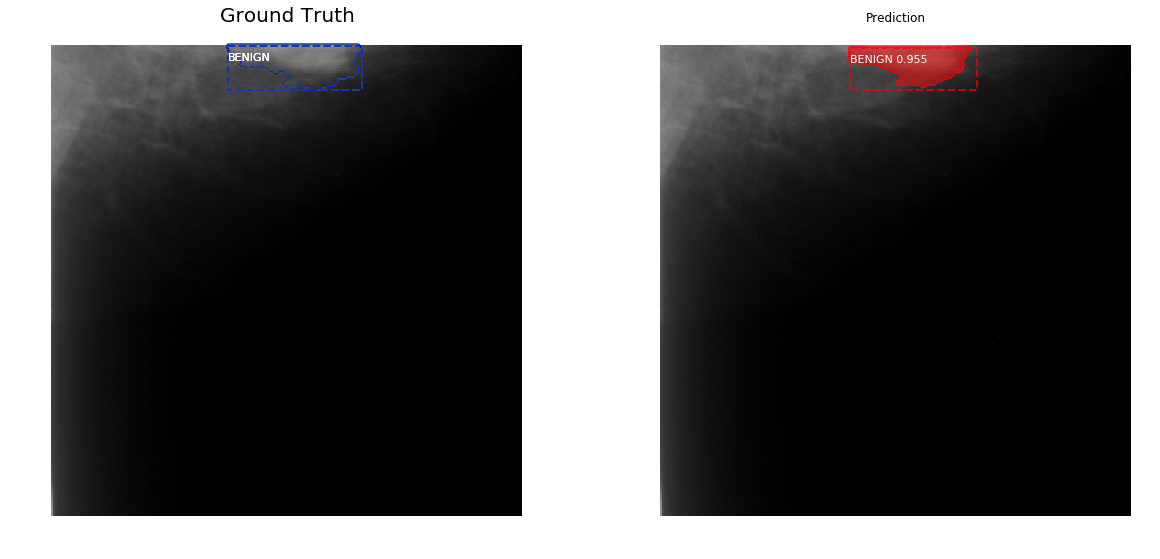

In [22]:
# Test on a random image
#image_id = random.choice(dataset_val.image_ids)
image_id = 12
print('Image id: {0}'.format(image_id))
original_image, image_meta, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

visualize.display_instances(original_image, gt_bbox[:,:4], gt_mask, gt_bbox[:,4], 
                            dataset_val.class_names, figsize=(8, 8),ax=ax1)


print()
start =  time.time()
results = model.detect([original_image], verbose=1)
end = time.time()

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax2)

ax1.set_title('Ground Truth', fontsize=20)
ax2.set_title('Prediction', fontsize=20)

fig.subplots_adjust(hspace=50)

print('Detection time = {0} seconds'.format(end-start))

# Ground Truth

Image id: 0
data/Mass-Test Full Mammogram Patches1024 NR/Mass-Test_P_01912_RIGHT_CC-T1-A0-W1024-H1024-HS1024-VS1024-R2-C2-m.png
data/Mass-Test Full ROI Patches1024 NR/Mass-Test_P_01912_RIGHT_CC_1_mask-T1-A0-W1024-H1024-HS1024-VS1024-R2-C2-m.png
original_image           shape: (256, 256, 3)         min:    0.00000  max:  207.00000
image_meta               shape: (12,)                 min:    0.00000  max: 1024.00000
gt_bbox                  shape: (3, 5)                min:    3.00000  max:  256.00000
gt_mask                  shape: (256, 256, 3)         min:    0.00000  max:  255.00000


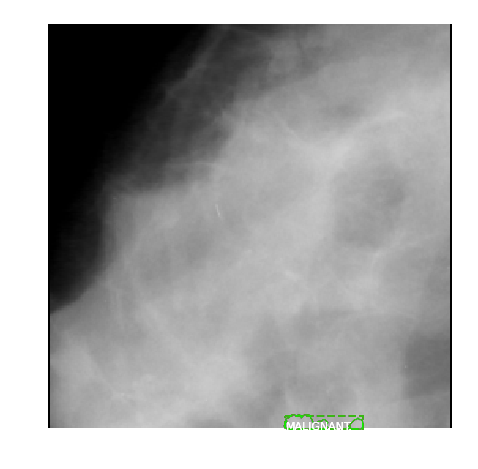

In [9]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
#image_id = 110
print('Image id: {0}'.format(image_id))
original_image, image_meta, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox[:,:4], gt_mask, gt_bbox[:,4], 
                            dataset_val.class_names, figsize=(8, 8))


# Prediction

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  207.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  103.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  256.00000

*** No instances to display *** 

Detection time = 4.7179529666900635 seconds


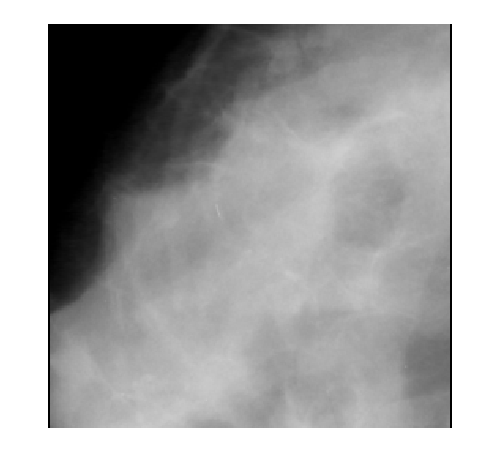

In [10]:
start =  time.time()
results = model.detect([original_image], verbose=1)
end = time.time()

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

print('Detection time = {0} seconds'.format(end-start))

In [16]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# Class Evaluation

In [31]:

##image_ids = np.random.choice(dataset_val.image_ids, 2)
image_ids = dataset_val.image_ids

##APs = []
image_paths = []
source_classes = []
target_classes = []
match_classes = []
match_cases = defaultdict(int)


for image_id in image_ids:
    print('Image id: {0}'.format(image_id))
    # Load image and ground truth data
    image, image_meta, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    ##AP, precisions, recalls, overlaps =\
    ##    utils.compute_ap(gt_bbox[:,:4], gt_bbox[:,4],
    ##                     r["rois"], r["class_ids"], r["scores"], iou_threshold=0.5)
    ##APs.append(AP)
    
    mask, source_class = dataset_val.load_mask(image_id)
    target_class = r["class_ids"]
    imagepath = dataset_val.image_reference(image_id)
    prefix, p, patientid, side, suffix = imagepath.split('_')
    view, tumor, angle, patch_width, patch_height, hstride, vstride, row, column, pathext = suffix.split('-')
    pathology, ext = pathext.split('.')
    
    key = str(patientid) + side + view + tumor + pathology
    print(key)
    match_cases[key] = 0
    
    print('Source class')
    print(source_class)
    print('Target class')
    print(target_class)
    
    source_classes.append(source_class[0])
    

    if len(target_class) == 0:
        target_classes.append(target_class)
        match_classes.append(0)
    elif len(target_class) == 1:
        target_classes.append(target_class[0])
        match = 1 if source_class[0] == target_class[0] else 0
        match_classes.append(match)
        if match == 1: # if matched then set to 1
            match_cases[key] = 1
    else:
        target_classes.append(target_class[0])
        match = 0
        for z in target_class:
            if source_class[0] == z:
                match = 1

        match_classes.append(match)
        if match == 1: # if matched then set to 1
            match_cases[key] = 1
        
    image_paths.append(dataset_val.image_reference(image_id))
    
    
print(match_cases)    
##print("mAP: ", np.mean(APs))

count = 0
total = 0
for k, v in match_cases.items():
    count += 1
    total += v
    
print('case accuracy: ', total/count)

print('accuracy: ', np.mean(match_classes))

Image id: 0
data/Mass-Test Full Mammogram Patches1024 NR/Mass-Test_P_01912_RIGHT_CC-T1-A0-W1024-H1024-HS1024-VS1024-R2-C2-m.png
data/Mass-Test Full ROI Patches1024 NR/Mass-Test_P_01912_RIGHT_CC_1_mask-T1-A0-W1024-H1024-HS1024-VS1024-R2-C2-m.png
data/Mass-Test Full ROI Patches1024 NR/Mass-Test_P_01912_RIGHT_CC_1_mask-T1-A0-W1024-H1024-HS1024-VS1024-R2-C2-m.png
01912RIGHTCCT1m
Source class
[3 3 3]
Target class
[]
Image id: 1
data/Mass-Test Full Mammogram Patches1024 NR/Mass-Test_P_01912_RIGHT_CC-T1-A0-W1024-H1024-HS1024-VS1024-R3-C2-m.png
data/Mass-Test Full ROI Patches1024 NR/Mass-Test_P_01912_RIGHT_CC_1_mask-T1-A0-W1024-H1024-HS1024-VS1024-R3-C2-m.png
data/Mass-Test Full ROI Patches1024 NR/Mass-Test_P_01912_RIGHT_CC_1_mask-T1-A0-W1024-H1024-HS1024-VS1024-R3-C2-m.png
01912RIGHTCCT1m
Source class
[3 3 3]
Target class
[3]
defaultdict(<class 'int'>, {'01912RIGHTCCT1m': 1})
case accuracy:  1.0
accuracy:  0.5
